# Q1

In [1]:
import pandas as pd

df = pd.read_csv('q1/click_event_log.csv')
df.head()

,user_id,ad_id,clicked_on_ad
0,20,308,0
1,35,270,0
2,36,168,0
3,21,479,0
4,86,321,0


### Q1.a

In [2]:
X= df[['user_id', 'ad_id']]
y = df['clicked_on_ad'].values

# no train_test_split without defining conditional probabilities on UNKNOWN features.
# For example, with train_test_split, it is possible that the training set never sees one
# features. Hence, it cannot make a prediction on the test set. Due to the shortness of time,
# do not perform train_test_split

In [3]:
P_click = df['clicked_on_ad'].mean()
P_no_click = 1 - P_click

df_user_id = pd.crosstab(df['user_id'], df['clicked_on_ad'])
df_ad_id = pd.crosstab(df['ad_id'], df['clicked_on_ad'])

# Laplace Smoothed
temp_user = df_user_id.apply(lambda row: (row[1] + 1.0) / (sum(row) + 1.0), axis=1)
temp_ad = df_ad_id.apply(lambda row: (row[1] + 1.0) / (sum(row) + 1.0), axis=1)

p_click_given_user = dict(temp_user)
p_no_click_given_user = dict(1 - temp_user)
p_click_given_ad = dict(temp_ad)
p_no_click_given_ad = dict(1 - temp_ad)

In [4]:
def predict_proba(user_id, ad_id): # this function is a bit hard coded
    p_click_given_features = p_click_given_user[user_id] * p_click_given_ad[ad_id]
    p_no_click_given_features = p_no_click_given_user[user_id] * p_no_click_given_ad[ad_id]
    return p_click_given_features / (p_click_given_features + p_no_click_given_features)

In [5]:
print("Predicted Probability for user 12 and ad 10: {}".format(predict_proba(12, 10)))
print("Predicted Probability for user 50 and ad 177: {}".format(predict_proba(50, 177)))
print("Predicted Probability for user 13 and ad 241: {}".format(predict_proba(13, 241)))

Predicted Probability for user 12 and ad 10: 0.0272108843537
Predicted Probability for user 50 and ad 177: 0.0167224080268
Predicted Probability for user 13 and ad 241: 0.08


### CAVEAT:
Due to not running train_test_split, I am unable to run metrics on independent test set. The dataset is fairly sparse, so the predictions are nothing special--always predicts no click. Perhaps, naive bayes is more susceptible to unbalanced classes.

In [6]:
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

prediction_probabilities = []
for user, ad in (df[['user_id', 'ad_id']]).values:
    prediction_probabilities.append(predict_proba(user, ad))

print("AUC: {}".format(roc_auc_score(df['clicked_on_ad'], prediction_probabilities)))
print('Accuracy: {}'.format(accuracy_score(df['clicked_on_ad'], np.round(prediction_probabilities).astype('int'))))
confusion_matrix(df['clicked_on_ad'], np.round(prediction_probabilities).astype('int'))

AUC: 0.762791058824
Accuracy: 0.85


array([[4250,    0],
       [ 750,    0]])

### Q1.b

In [7]:
from collections import defaultdict
import numpy as np

user_ad_dataset = defaultdict(dict) # each user with ad as key and clicks as value {'user14': {'ad32': [1 ,0, 0]}}

for user_id, ad_id, clicked_on_ad in df.values:
    if ad_id not in user_ad_dataset[user_id]:
        user_ad_dataset[user_id][ad_id] = [clicked_on_ad]
    else:
        user_ad_dataset[user_id][ad_id].append(clicked_on_ad)

In [8]:
import itertools

for user_id in user_ad_dataset:
    average_ctr = np.mean(list(itertools.chain.from_iterable(user_ad_dataset[user_id].values())))
    pseudo_clicks = np.random.choice([0.0, 1.0], 10, p=[1- average_ctr, average_ctr])
    for ad_id in user_ad_dataset[user_id]:
        user_ad_dataset[user_id][ad_id] = np.mean(user_ad_dataset[user_id][ad_id])
    for ad_id, click in zip(xrange(501, 511), pseudo_clicks): # adding pseudo clicks for pseudo ads
        user_ad_dataset[user_id][ad_id] = click

In [9]:
from math import sqrt
from itertools import permutations

def similarity_score(person1, person2, dataset):
    """Returns the euclidean distance score of person 1 and 2"""
    both_viewed = set(dataset[person1]) & set(dataset[person2])
    if len(both_viewed) == 0:
            return 0.0
    else:
        sum_of_eclidean_distance = []
        for item in both_viewed:
            sum_of_eclidean_distance.append(pow(dataset[person1][item] - dataset[person2][item], 2))        
        return 1 / (1 + sqrt(sum(sum_of_eclidean_distance)))

user_user_similarity = np.eye(101)

for user1, user2 in permutations(sorted(set(df['user_id'])), 2):
    user_user_similarity[user1, user2] = similarity_score(user1, user2, user_ad_dataset)

user_user_similarity = user_user_similarity[1:, 1:] # readjust for index starting at 0

In [10]:
pd.DataFrame(user_user_similarity, index=range(1, 101), columns=range(1, 101))

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,1.000000,0.366025,0.366025,0.333333,0.366025,0.414214,0.309017,0.333333,0.333333,0.366025,...,0.333333,0.333333,0.356789,0.366025,0.333333,0.366025,0.366025,0.366025,0.500000,0.333333
2,0.366025,1.000000,0.414214,0.414214,0.366025,0.414214,0.333333,0.500000,0.309017,0.500000,...,0.414214,0.366025,0.333333,0.414214,0.333333,0.289898,0.366025,0.366025,0.274292,1.000000
3,0.366025,0.414214,1.000000,0.366025,0.414214,0.366025,0.333333,0.500000,0.366025,0.500000,...,0.500000,0.366025,0.356789,0.366025,1.000000,0.366025,0.387426,0.366025,0.309017,0.366025
4,0.333333,0.414214,0.366025,1.000000,0.500000,0.366025,0.333333,0.366025,0.289898,0.366025,...,0.366025,0.274292,0.309017,0.309017,0.366025,0.309017,0.333333,0.333333,0.274292,0.500000
5,0.366025,0.366025,0.414214,0.500000,1.000000,0.414214,0.333333,0.414214,0.289898,0.414214,...,0.366025,0.333333,0.333333,0.366025,0.414214,0.309017,0.356789,0.414214,0.333333,0.366025
6,0.414214,0.414214,0.366025,0.366025,0.414214,1.000000,0.414214,0.414214,0.333333,0.500000,...,1.000000,0.414214,0.500000,0.500000,0.500000,0.366025,0.333333,0.414214,0.333333,0.414214
7,0.309017,0.333333,0.333333,0.333333,0.333333,0.414214,1.000000,0.414214,0.333333,0.309017,...,0.414214,0.309017,0.366025,0.366025,0.333333,0.366025,0.333333,0.366025,0.309017,0.366025
8,0.333333,0.500000,0.500000,0.366025,0.414214,0.414214,0.414214,1.000000,0.274292,0.414214,...,0.333333,0.414214,0.366025,0.500000,0.414214,0.333333,0.326632,0.414214,0.333333,0.366025
9,0.333333,0.309017,0.366025,0.289898,0.289898,0.333333,0.333333,0.274292,1.000000,0.309017,...,0.261204,0.261204,0.289898,0.309017,0.333333,0.274292,0.274292,0.309017,0.289898,0.289898
10,0.366025,0.500000,0.500000,0.366025,0.414214,0.500000,0.309017,0.414214,0.309017,1.000000,...,1.000000,0.366025,0.500000,0.414214,0.414214,0.414214,0.414214,0.414214,0.333333,0.414214


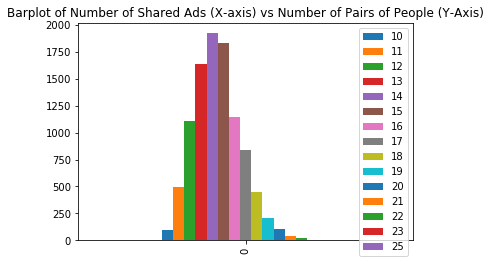

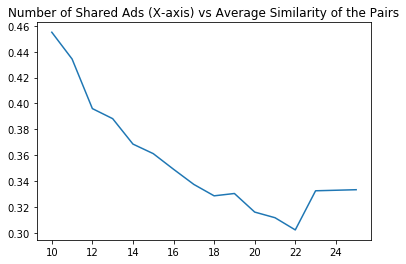

In [11]:
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

ads_in_common = defaultdict(list)
for user1, user2 in permutations(sorted(set(df['user_id'])), 2):
    number_of_common_ads = len(set(user_ad_dataset[user1]) & set(user_ad_dataset[user2]))
    ads_in_common[number_of_common_ads].append(similarity_score(user1, user2, user_ad_dataset))

pd.DataFrame(dict((key, [len(value)]) for key, value in ads_in_common.iteritems())).plot(kind='bar')
plt.title('Barplot of Number of Shared Ads (X-axis) vs Number of Pairs of People (Y-Axis)')
plt.show()

for number_of_common_ads in ads_in_common:
    ads_in_common[number_of_common_ads] = np.mean(ads_in_common[number_of_common_ads])

plt.plot(ads_in_common.keys(), ads_in_common.values())
plt.title('Number of Shared Ads (X-axis) vs Average Similarity of the Pairs')
plt.show()

It appears as if number of shared ads go up between users, then the similarity of the users tends to go down. That makes sense since if people have more shared ads, there is higher probability that they will have different clicking patterns. However, for the people that share the most ads, their similarity is very high--however, that can be an artifact of very few people share large number of ads. Hence, this group of people experience the highest volatility in terms of average similarity.

### Caveat: 
This user similiarity matrix is generated by looking at each user and comparing the ads that mutual looked at. It then compares whether if they clicked or didn't click the ad. It does NOT take account of the ads that 1 person looked at but the other person hadn't seen. I attempted to mitigate this problem by including 10 ads that all users have seen. Nonetheless, these similarity numbers can appear inflated because for many users. The good news is that the similarity matrix is no longer sparse.

# Q2

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

df = pd.read_csv('q2/satelite_20.csv')
df.head()

,log_azimuth,log_altitiude,lens_size,months_in_operation,observed_image_output
0,2.351222,2.996789,8.041122,1,0
1,2.379440,3.050773,5.448220,3,0
2,2.441207,3.071607,2.134721,3,0
3,2.454324,3.127072,7.271947,1,0
4,2.465330,3.162127,6.854447,0,0


Counter({0: 51, 1: 51, 2: 51})


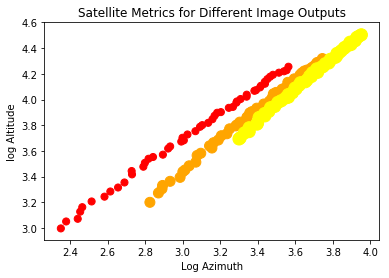

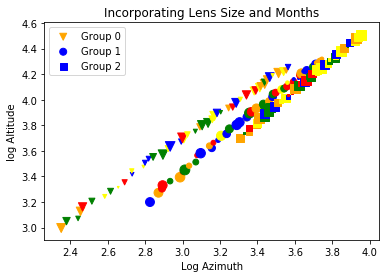

In [2]:
# Exploratory Data Analysis
from collections import Counter

print(Counter(df['observed_image_output']))

color_dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

plt.scatter(df['log_azimuth'], df['log_altitiude'], 
            c=[color_dict[element] for element in df['observed_image_output']],
           s=(df['observed_image_output'] + 1) * 50)
plt.xlabel('Log Azimuth'); plt.ylabel('log Altitude')
plt.title('Satellite Metrics for Different Image Outputs')
plt.show()

for grp in df.groupby('observed_image_output'): # adding lens size and observed_image_output
    df_temp = grp[1]
    plt.scatter(df_temp['log_azimuth'], df_temp['log_altitiude'],
                c=[color_dict[element] for element in df_temp['months_in_operation']],
                s=(df_temp['lens_size']) * 10, 
                marker=['v', 'o', 's'][grp[0]], 
                label='Group {}'.format(grp[0]))
    plt.legend()
    plt.xlabel('Log Azimuth'); plt.ylabel('log Altitude')
    plt.title('Incorporating Lens Size and Months')

### Q2.a

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

rescaler = preprocessing.Normalizer()
X = rescaler.fit_transform(df[['log_azimuth', 'log_altitiude']])
y = df['observed_image_output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


n_neighbors = 5
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(confusion_matrix(y_test, predictions)) 

[[10  0  0]
 [ 0  7  2]
 [ 0  0 12]]


### Q2.b

In [4]:
df_test = pd.read_csv('q2/satelite_20_test.csv')
print(clf.predict(df_test[['log_azimuth', 'log_altitiude']])) # yay! correct predictions

[0 0 0 0 2 2 1 1 2 2 2 2]


### Discussion
Took me many tries. I used XGBoost and Random Forest (with Out-of-Bag-Error) with cross validation and grid search. I wish I had more time so that I would be comfortable working out the Explatory Data Analysis with plots.

From inspection of the plot, I determined that log_azimuth and log_altitiude are the main features. I do not know lens_size and months_in_operation. My only concern is that I performed manual feature selection/importance; but I assume these features are important because the satellite travels in a mechanical way with minimal deviance from its path. In addition, below is a random forest model that shows feature importance that supports my beliefs.

With different train_test_split, I've run the K-Nearest Neighbors (KNN) model multiple times and most predictions for the validation set are correct. The errors are when it cannot determine whether the picture was from group 1 or 2 since the satellite moves in similar trajectories for those. Ideally, I wanted to create a classifier that checks distance from each image_output's satellite trajectory. I settled with KNN because it appears to work well and I'm low on time.

### Deprecated: Random Forest Model with Feature Importance

OOB score: 0.732026143791


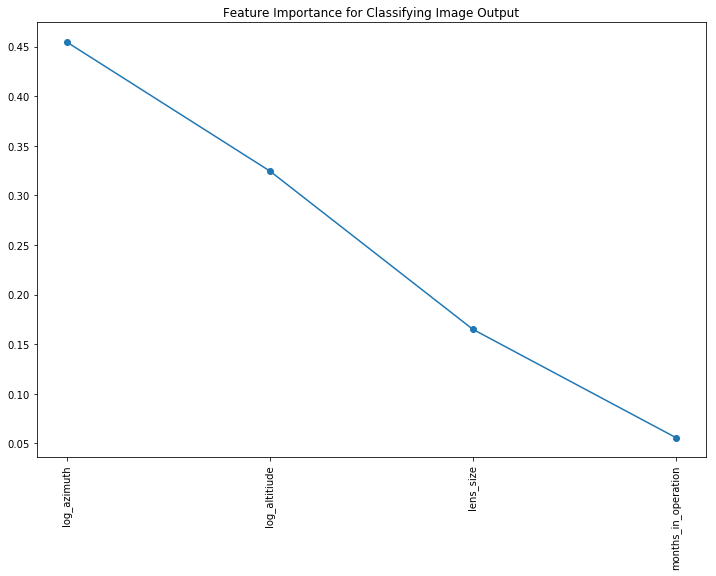

In [5]:
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('q2/satelite_20.csv')

X = df.drop('observed_image_output', axis=1)
y = df['observed_image_output']

clf = RandomForestClassifier(n_estimators=100, oob_score=True)
clf.fit(X, y)
print("OOB score: {}".format(clf.oob_score_))

xlabels = df.columns[:-1]
plt.figure(figsize=(12, 8))
plt.plot(clf.feature_importances_, 'o-')
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.title("Feature Importance for Classifying Image Output")
plt.show()

# Q3

In [1]:
import pandas as pd

df_dams = pd.read_csv('q3/dams.csv')
df_dams.head()

,from_dam,to_dam,amount,week
0,2,7,685,1
1,3,8,423,2
2,6,9,1026,3
3,7,9,817,4
4,3,8,2858,5


### Q3.a 

In [2]:
from collections import defaultdict
import numpy as np

def average(lst):
        return sum(lst) / float(len(lst)) if lst else 0.0

dam_connections = defaultdict(list)
for from_dam, to_dam, amount in df_dams.drop('week', axis=1).values:
    connection_pair = tuple(sorted([from_dam, to_dam]))
    dam_connections[connection_pair].append(amount)
    

flow_matrix = np.zeros((11, 11))
for dam_pair in dam_connections:
    flow_matrix[dam_pair] = average(dam_connections[dam_pair])
    flow_matrix[dam_pair[::-1]] = average(dam_connections[dam_pair])
flow_matrix = flow_matrix[1:, 1:] # readjust for index starting at 0
pd.DataFrame(flow_matrix, index=range(1, 11), columns=range(1, 11))

,1,2,3,4,5,6,7,8,9,10
1,2018.000000,1309.50,2408.00,1250.000000,1822.500000,631.000000,653.000000,1094.666667,1034.0,895.0
2,1309.500000,0.00,753.00,319.000000,1684.000000,2618.000000,709.250000,1186.000000,1092.0,1169.0
3,2408.000000,753.00,1677.50,1704.500000,212.000000,1846.750000,0.000000,1640.500000,2865.0,1892.0
4,1250.000000,319.00,1704.50,0.000000,0.000000,2409.000000,1214.000000,1552.666667,1114.2,1499.5
5,1822.500000,1684.00,212.00,0.000000,532.000000,1155.666667,1106.333333,1496.000000,0.0,2586.5
6,631.000000,2618.00,1846.75,2409.000000,1155.666667,0.000000,2610.000000,1562.500000,1582.5,1685.5
7,653.000000,709.25,0.00,1214.000000,1106.333333,2610.000000,0.000000,1386.500000,1178.0,2451.0
8,1094.666667,1186.00,1640.50,1552.666667,1496.000000,1562.500000,1386.500000,1261.000000,2013.0,2145.0
9,1034.000000,1092.00,2865.00,1114.200000,0.000000,1582.500000,1178.000000,2013.000000,0.0,1138.0
10,895.000000,1169.00,1892.00,1499.500000,2586.500000,1685.500000,2451.000000,2145.000000,1138.0,1927.0


In [3]:
on_or_off = np.bool_(flow_matrix) * 1
pd.DataFrame(on_or_off, index=range(1, 11), columns=range(1, 11))

,1,2,3,4,5,6,7,8,9,10
1,1,1,1,1,1,1,1,1,1,1
2,1,0,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,0,1,1,1
4,1,1,1,0,0,1,1,1,1,1
5,1,1,1,0,1,1,1,1,0,1
6,1,1,1,1,1,0,1,1,1,1
7,1,1,0,1,1,1,0,1,1,1
8,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,0,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1


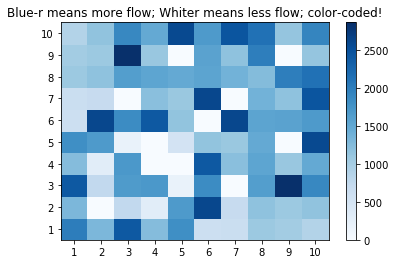

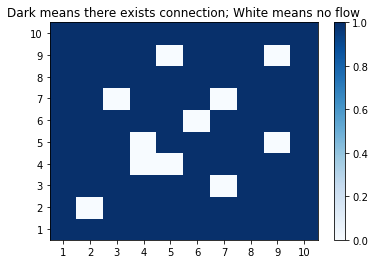

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots()
heatmap = axis.pcolor(flow_matrix, cmap=plt.cm.Blues)
plt.colorbar(heatmap)

axis.set_xticks(np.arange(1, 11) - 0.5)
axis.set_yticks(np.arange(1, 11) - 0.5)
axis.set_xticklabels(range(1, 11))
axis.set_yticklabels(range(1, 11))
plt.title('Blue-r means more flow; Whiter means less flow; color-coded!')
# Modelled on average flow between dams

fig, axis = plt.subplots()
heatmap = axis.pcolor(on_or_off, cmap=plt.cm.Blues)
plt.colorbar(heatmap)

axis.set_xticks(np.arange(1, 11) - 0.5)
axis.set_yticks(np.arange(1, 11) - 0.5)
axis.set_xticklabels(range(1, 11))
axis.set_yticklabels(range(1, 11))
plt.title('Dark means there exists connection; White means no flow');

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


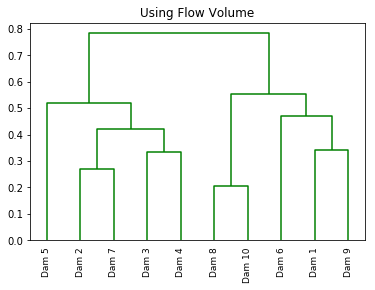

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


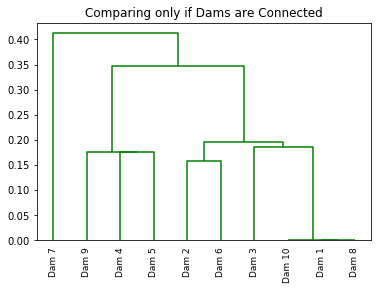

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

distxy = squareform(pdist(flow_matrix, metric='cosine'))
link = linkage(distxy, method='complete') # there are other distance measures
dendro = dendrogram(link, color_threshold=1.5, leaf_font_size=9,
                    labels=['Dam {}'.format(dam) for dam in 
                            sorted(set(df_dams.from_dam))], 
                    leaf_rotation=90)
plt.title('Using Flow Volume')
plt.show()

distxy = squareform(pdist(on_or_off, metric='cosine'))
link = linkage(distxy, method='complete')
dendro = dendrogram(link, color_threshold=1.5, leaf_font_size=9,
                    labels=['Dam {}'.format(dam) for dam in 
                            sorted(set(df_dams.from_dam))], 
                    leaf_rotation=90)
plt.title('Comparing only if Dams are Connected')

### Q3.b

In [6]:
dam_volume = defaultdict(dict)
all_dams = set(df_dams.from_dam)

for dam in all_dams:
    dam_volume[dam][0] = 10000

for from_dam, to_dam, amount, week in df_dams.values:
    if from_dam != to_dam:
        dam_volume[from_dam][week] = dam_volume[from_dam][week - 1] - amount
        dam_volume[to_dam][week] = dam_volume[to_dam][week - 1] + amount
    else:
        dam_volume[from_dam][week] = dam_volume[from_dam][week - 1]
    
    for dam in (all_dams - set([from_dam, to_dam])):
        dam_volume[dam][week] = dam_volume[dam][week - 1]
        
    assert sum(dam_volume[dam][week] for dam in all_dams) == \
        100000, 'problem' # make sure all water is conserved

In [7]:
df_log = pd.read_csv('q3/foremen_log.csv')

def get_cracked_dams(string):
    if string == 'none':
        return None
    else:
        return list(int(number) for number in string.split(', '))

df_log['dams_cracked'] = df_log['dams_cracked'].apply(get_cracked_dams)

pd.DataFrame(dam_volume).head() # ledger of dam volume

,1,2,3,4,5,6,7,8,9,10
0,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,10000,9315,10000,10000,10000,10000,10685,10000,10000,10000
2,10000,9315,9577,10000,10000,10000,10685,10423,10000,10000
3,10000,9315,9577,10000,10000,8974,10685,10423,11026,10000
4,10000,9315,9577,10000,10000,8974,9868,10423,11843,10000


In [8]:
volume_in_cracked_dams = defaultdict(list)
uncracked_dam_volumes = dict()

for week, dams_cracked in df_log.values:
    if dams_cracked:
        for dam in dams_cracked:
            volume_in_cracked_dams[dam].append(dam_volume[dam][week])
        uncracked_dams = all_dams - set(dams_cracked)
        uncracked_dam_volumes[week] = sorted(dam_volume[dam][week] 
                                             for dam in uncracked_dams)[-1]
    elif dams_cracked is None:
        uncracked_dam_volumes[week] = sorted(dam_volume[dam][week]
                                             for dam in all_dams)[-1]
    else:
        "Print unexpected error"

In [9]:
def predict_crack(dam_volume_list, dam_threshold_no_crack, dam_threshold_crack):
    cracked_dams = []
    undetermined_dams = []
    for dam_number, volume in enumerate(dam_volume_list, 1):
        if volume >= dam_threshold_crack:
            cracked_dams.append(dam_number)
        elif volume > dam_threshold_no_crack:
            undetermined_dams.append(dam_number)
    
    if (not cracked_dams and not undetermined_dams):
        return None
    elif not undetermined_dams:
        return cracked_dams
    else:
        return cracked_dams, undetermined_dams

dam_threshold_no_crack = max(uncracked_dam_volumes.values())
dam_threshold_crack = min(reduce(lambda x, y: x + y, volume_in_cracked_dams.values()))
    
dam_predictions = pd.DataFrame(dam_volume).apply(lambda row: 
    predict_crack(row, dam_threshold_no_crack, dam_threshold_crack), axis=1)
print(pd.Series(dam_predictions)[1:31].values == df_log['dams_cracked'].values).all() 
# check if all dam cracking predictions match the ground truth

True


### Discussion
If None, then no dams are broken.  
Else, there can be 1 or 2 lists. The first list is known cracked dams. If the second list exists, it would be dams that are not known whether to be cracked or not since they are below the minimum
cracked dam volume but also above the highest known uncracked dam volume. 

In [10]:
dam_predictions

0                 None
1                 None
2                 None
3                 None
4                 None
5                 None
6                 None
7                 None
8                 None
9                 None
10                None
11                 [9]
12                 [9]
13                 [9]
14                 [9]
15                 [9]
16                 [9]
17                 [9]
18                 [9]
19                 [4]
20              [4, 8]
21           [4, 8, 9]
22           [4, 8, 9]
23           [4, 8, 9]
24           [4, 8, 9]
25              [4, 8]
26              [4, 8]
27              [4, 8]
28                 [8]
29                 [8]
            ...       
66    ([1, 4, 8], [6])
67       ([1, 8], [6])
68       ([1, 8], [6])
69       ([1, 8], [6])
70       ([1, 8], [6])
71       ([1, 8], [6])
72       ([1, 8], [6])
73       ([1, 8], [6])
74              [1, 8]
75              [1, 8]
76              [1, 8]
77              [1, 8]
78       ([